# Predicting differences between local and benchmark decisions: Identifying patients that low thrombolsying units would not give thrombolysis to whereas the majority of benchmark hospitals would

## Plain English summary 

In this experiment we compare decisions between the top and bottom 30 hospitals (as ranked by the predicted thrombolysis use in the same 10k cohort of patients). We take those patients that would be given thrombolysis by the majority of the top 30 thombolysing hospitals (we also call these 'benchmark' hospitals), and predict when the bottom 30 hospitals would make a different decision (i.e. decide *not* to thrombolyse).

This notebook uses a single model for all of the hospitals, with the hosptial feature not included in the model. This experiment is repeated in two other notebooks for comparison. These three related notebooks are:
* 06a_predict_differences_between_local_and_benchmark_key_features.ipynb - uses a single model for all hospitals, the hospital feature is not included in the model.
* 06b_predict_differences_between_local_and_benchmark_key_features.ipynb - uses a single model for all hospitals, with the hospital feature included as a one hot encoded feature.
* 06c_predict_differences_between_local_and_benchmark_key_features.ipynb - uses a separate model per hospital

We find that low thrombolysing hospitals are less likely to give thrombolysis to patients with:

* Low or very high stroke severity
* An estimated (not precise) stroke onset time
* Prior disability
* A longer arrival-to-scan time
* A longer inset-to-arrival time
* Use of of AF anticoagulants

## Model and data

A single XGBoost model is trained on stratified k-fold cross-validation data. A single model is fitted for all of the hosptials (with hospital ID not included in the model) to predict whether a patient (which gets thrombolysis from the benchmark majority vote) would *not* get thrombolysis from the bottom 30 hospitals. It uses these 7 features: 

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)

And one target feature:
* Different decision: 1 = Yes (thrombolysis at benchmark only), 0 = No (thrombolysis at both local and benchmark)

## Aims

* Of all those patients thrombolysed by benchmark decision, build an XGBoost model to predict which patients would be *not* be thrombolysed at a local hospital. Include patients that attend one of the 30 lowest thrombolysing hospitals (for the 10k patient cohort).
* Investigate the model predictions using SHAP.

## Observations

* We can predict those that will *not* receive thrombolysis at a local unit, out of those who will be thrombolysed by the majority of the benchmark hospitals, with 67% accuracy (AUC 0.733).

* The five most important distinguishing features are:
    * Stroke severity
    * Prior disability level
    * Precise onset time
    * Arrival-to-scan time
    * Onset-to-arrival time
    
## A note on Shap values

Shap values are usually reported as *log odds shifts* in model predictions. For a description of the relationships between probability, odds, and Shap values (log odds shifts) see [here](../introduction/odds_prob.md).

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

import json
import shap

#import importlib
#from utils import waterfall
## Force package to be reloaded
#importlib.reload(waterfall) 

## Set filenames

In [2]:
number_key_features = 8
model_text = (f'xgb_decision_comparison_{number_key_features}_features_single_'
              f'model')
notebook = '06a'

## Function to calculate accuracy measures

In [3]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Load the data that we need from three data files:
1. per patient the thrombolysis decision for their local and benchmark hostpials
1. per patient the feature data (arrival to scan time, infarction, stroke severity, precise onset time, local hospital, anticoagulants, onset to arrival time)
1. predicted thrombolysis rate for each hosptial for the 10K patient cohort

### Load thrombolysis decision data
We have data for each patient on their local hospital, whether their local hospital gave thrombolysis, whether the model predicted their local hospital would give thrombolysis (with probability), whether the benchmark hospital majority vote gave thrombolysis.

In [5]:
thrombolysis_decision_data = pd.read_csv(
 f'./predictions/05_xgb_{number_key_features}_features_benchmark_decisions.csv')

In [6]:
thrombolysis_decision_data

,Home hospital,Observed IVT,Predicted IVT,Predicted probability IVT,Benchmark majority vote
0,TXHRP7672C,1,1,0.880155,1.0
1,SQGXB9559U,1,1,0.627783,1.0
2,LFPMM4706C,0,0,0.042199,0.0
3,MHMYL4920B,0,0,0.000084,0.0
4,EQZZZ5658G,1,1,0.916311,1.0
...,...,...,...,...,...
88787,OYASQ1316D,1,1,0.917107,1.0
88788,SMVTP6284P,0,0,0.023144,0.0
88789,RDVPJ0375X,0,0,0.089444,0.0
88790,FAJKD7118X,0,1,0.615767,1.0


Add label where benchmark = 1, but observed = 0

In [7]:
thrombolysis_decision_data['Benchmark Yes Observed No'] = (
    (thrombolysis_decision_data['Benchmark majority vote'] == 1) &
    (thrombolysis_decision_data['Observed IVT'] == 0))

In [8]:
thrombolysis_decision_data

,Home hospital,Observed IVT,Predicted IVT,Predicted probability IVT,Benchmark majority vote,Benchmark Yes Observed No
0,TXHRP7672C,1,1,0.880155,1.0,False
1,SQGXB9559U,1,1,0.627783,1.0,False
2,LFPMM4706C,0,0,0.042199,0.0,False
3,MHMYL4920B,0,0,0.000084,0.0,False
4,EQZZZ5658G,1,1,0.916311,1.0,False
...,...,...,...,...,...,...
88787,OYASQ1316D,1,1,0.917107,1.0,False
88788,SMVTP6284P,0,0,0.023144,0.0,False
88789,RDVPJ0375X,0,0,0.089444,0.0,False
88790,FAJKD7118X,0,1,0.615767,1.0,True


### Load feature data

We have feature data (arrival to scan time, infarction, stroke severity, precise onset time, local hospital, anticoagulants, onset to arrival time) for each patient.

Combine the feature data and thrombolysis decision data for patients.

In [9]:
feature_data = pd.read_csv(f'./predictions/05_xgb_{number_key_features}_'
                           f'features_test_features_collated.csv')
feature_data.rename(columns=dict_feature_name, inplace=True)
feature_data['Benchmark majority vote'] = \
    thrombolysis_decision_data['Benchmark majority vote'] * 1

In [10]:
feature_data

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Thrombolysis,Benchmark majority vote
0,17.0,1,14.0,1,0,TXHRP7672C,0,186.0,1,1.0
1,25.0,1,6.0,1,0,SQGXB9559U,0,71.0,1,1.0
2,138.0,1,2.0,1,0,LFPMM4706C,0,67.0,0,0.0
3,21.0,0,11.0,1,0,MHMYL4920B,0,86.0,0,0.0
4,8.0,1,16.0,1,0,EQZZZ5658G,0,83.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...
88787,3.0,1,11.0,1,1,OYASQ1316D,0,140.0,1,1.0
88788,69.0,1,3.0,0,4,SMVTP6284P,0,189.0,0,0.0
88789,63.0,1,3.0,1,1,RDVPJ0375X,0,154.0,0,0.0
88790,14.0,1,4.0,1,0,FAJKD7118X,0,77.0,0,1.0


## Restrict dataset for model

#### Restrict data to the 30 lowest thrombolysing hospitals
Load data on predicted 10k cohort thrombolysis use at each hospital (from notebook 04). Restrict dataset to the 30 hospitals with the lowest thrombolysis rate on the same set of 10k patients.


In [11]:
thrombolysis_by_hosp = pd.read_csv(f'./output/04_xgb_{number_key_features}_'
                               f'features_10k_thrombolysis_rate_by_hosp.csv', 
                               index_col='stroke_team')
thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', ascending=False, inplace=True)

Select the 30 hospitals with the lowest thrombolysis rates.

In [12]:
df_low_thrombolysing_hospitals = thrombolysis_by_hosp.tail(30)
low_thrombolysing_hospitals = list(df_low_thrombolysing_hospitals.index)

Restrict data to patients that attend one of the 30 hospitals with the lowest thrombolysis rate

In [13]:
mask = feature_data['Stroke team'].isin(low_thrombolysing_hospitals)
restricted_data = feature_data[mask]

Save data to plot later in the notebook

In [14]:
df_data_for_plot = restricted_data[['Stroke team', 'Benchmark majority vote', 'Thrombolysis']]

#### Restrict data to instances that the benchmark majority vote would give thrombolysis

In [15]:
mask = restricted_data['Benchmark majority vote'] == 1
restricted_data = restricted_data[mask]

Label those that are different

In [16]:
restricted_data['Different_decision'] = restricted_data['Thrombolysis'] == 0

Remove columns not to be used in model

In [17]:
cols_to_drop = ['Stroke team', 'Benchmark majority vote', 'Thrombolysis']
restricted_data.drop(cols_to_drop, axis=1, inplace=True)

In [18]:
restricted_data

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Different_decision
1,25.0,1,6.0,1,0,0,71.0,False
28,38.0,1,13.0,1,0,0,149.0,False
91,18.0,1,15.0,1,0,0,122.0,True
154,21.0,1,5.0,1,0,0,62.0,False
159,2.0,1,16.0,1,2,0,78.0,False
...,...,...,...,...,...,...,...,...
88667,66.0,1,16.0,1,0,0,46.0,True
88698,5.0,1,16.0,1,2,0,109.0,False
88740,10.0,1,5.0,1,0,0,67.0,True
88758,9.0,1,3.0,1,0,0,89.0,True


Show proportion of patients where the decision would differ between the low thrombolysing hospitals and the benchmark majority vote.

In [19]:
prop_diff = restricted_data['Different_decision'].mean()
print (f'Proportion with predicted different decision: {prop_diff:.3f}')

Proportion with predicted different decision: 0.462


### Plot overview of dataset
Plot a stacked barchart per hospital to show how many patients receive thromboloysis at either local or with the benchmark majority vote.

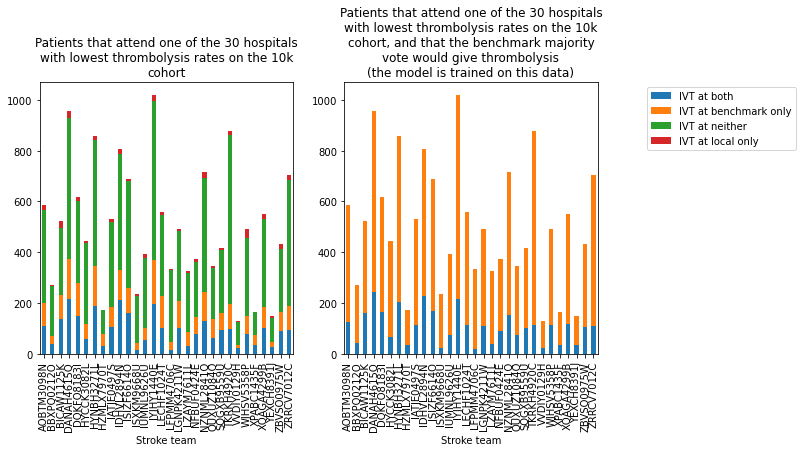

In [20]:
# Data for subplot 1

# Value "1" to represent patient is in this group
df_data_for_plot["temp"] = (df_data_for_plot["Thrombolysis"] +
                            df_data_for_plot["Benchmark majority vote"])

# Change temp=2 to be 1, and both temp=0 & 1 to be 0. 
df_data_for_plot["IVT at both"] = df_data_for_plot["temp"].copy(deep=True)
df_data_for_plot["IVT at both"].replace(to_replace=1, value=0, inplace=True)
df_data_for_plot["IVT at both"].replace(to_replace=2, value=1, inplace=True)

# Change temp=0 to be 1, and both temp=0 & 2 to be 0.
df_data_for_plot["IVT at neither"] = df_data_for_plot["temp"].copy(deep=True)
df_data_for_plot["IVT at neither"].replace(to_replace=1, value=2, inplace=True)
df_data_for_plot["IVT at neither"].replace(to_replace=0, value=1, inplace=True)
df_data_for_plot["IVT at neither"].replace(to_replace=2, value=0, inplace=True)

# Change temp=2 to be 0.
df_data_for_plot["temp"].replace(to_replace=2, value=0, inplace=True)
df_data_for_plot["IVT at local only"] = (df_data_for_plot["temp"] * 
                                         df_data_for_plot["Thrombolysis"])
df_data_for_plot["IVT at benchmark only"] = (
                                df_data_for_plot["temp"] * 
                                df_data_for_plot["Benchmark majority vote"])

# Store counts per hospital for each patient group
a = df_data_for_plot.groupby("Stroke team").sum()["IVT at both"]
df1 = pd.DataFrame(data=a)

a = df_data_for_plot.groupby("Stroke team").sum()["IVT at neither"]
df2 = pd.DataFrame(data=a)

a = df_data_for_plot.groupby("Stroke team").sum()["IVT at local only"]
df3 = pd.DataFrame(data=a)

a = df_data_for_plot.groupby("Stroke team").sum()["IVT at benchmark only"]
df4 = pd.DataFrame(data=a)

# Consolidate in DataFrame
df_low_30_hospitals = df1.join(df2, how='inner')
df_low_30_hospitals = df_low_30_hospitals.join(df3, how='inner')
df_low_30_hospitals = df_low_30_hospitals.join(df4, how='inner')

# Data for subplot 2

# Store counts per hospital for each patient group
a = df_data_for_plot.groupby("Stroke team").sum()["Thrombolysis"]
df1 = pd.DataFrame(data=a)
df1.rename(columns={"Thrombolysis":"IVT at both (local and benchmark)"}, 
           inplace=True)

a = df_data_for_plot.groupby("Stroke team").count()["Thrombolysis"]
df2 = pd.DataFrame(data=a)
df2.rename(columns={"Thrombolysis":"Population"}, inplace=True)

# Consolidate in DataFrame
df_low_30_hospitals_benchmark_yes = df1.join(df2, how='inner')
df_low_30_hospitals_benchmark_yes["IVT at benchmark only"] = (
    df_low_30_hospitals_benchmark_yes["Population"] - 
    df_low_30_hospitals_benchmark_yes["IVT at both (local and benchmark)"])

# Plot figure
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
df_low_30_hospitals[['IVT at both', 'IVT at benchmark only', 'IVT at neither',
                     'IVT at local only']].plot(
                            kind='bar', stacked=True, ax=ax1)
ax1.legend(bbox_to_anchor=[3,1])
ax1.set_title("Patients that attend one of the 30 hospitals\nwith lowest "
              "thrombolysis rates on the 10k\ncohort")

ax2 = fig.add_subplot(122)
df_low_30_hospitals_benchmark_yes[['IVT at both (local and benchmark)',
                                   'IVT at benchmark only']].plot(
                                    kind='bar', stacked=True, ax=ax2)
ax2.get_legend().remove()#bbox_to_anchor=[1,1.3])
ax2.set_title("Patients that attend one of the 30 hospitals\nwith lowest "
              "thrombolysis rates on the 10k\ncohort, and that the benchmark "
              "majority\nvote would give thrombolysis\n(the model is trained "
              "on this data)")
plt.show()

## Fit XGBoost model 

The dataset contains patients attending one of the 30 lowest thrombolysing hospitals (based on the 10k patient cohort) which would receive thrombolysis if the decision was made by the benchmark majority vote.

Train an XGBoost model to distinguish between the decisions made at a local hospital and the benchmark majority vote.

Create a single model for all of the hospitals.

### Set up X, y
X contains the independent features, y contains the target feature

In [21]:
X = restricted_data.drop('Different_decision', axis=1)
y = restricted_data['Different_decision']

Set up a stratified 5-fold split for the training and test data. Fit a XGBoost model on each split.

In [22]:
# Set up the stratified k-fold split
skf = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

# Set up list to store models
model_kfold = []

# Set up lists for k-fold fits
y_test_kfold = []
y_prob_kfold = []
y_pred_kfold = []
X_train_kfold = []
X_test_kfold = []
y_train_kfold = []
y_test_kfold = []
feature_importance_kfold = []

# Loop through the k-fold splits
k = 0
for train_index, test_index in skf.split(X, y):
    
    # Get X and y train/test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Store
    X_train_kfold.append(X_train)
    X_test_kfold.append(X_test)
    y_train_kfold.append(y_train)
    y_test_kfold.append(y_test)

    # Define model
    model = XGBClassifier(
        verbosity = 0, 
        scale_pos_weight=0.8, 
        random_state=42, 
        learning_rate=0.1)
    
    # Fit model
    model.fit(X_train, y_train)    
    model_kfold.append(model)
    
    # Get predicted probabilities
    y_prob = model.predict_proba(X_test)[:,1]
    y_prob_kfold.append(y_prob)
    
    # Get feature importances
    importance = model.feature_importances_
    feature_importance_kfold.append(importance)
    
    # Get class
    y_pred = model.predict(X_test)
    y_pred_kfold.append(y_pred)
    
    # Print accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy k-fold {k}: {accuracy:0.3f}')
    
    # Counter
    k += 1

Run 1, accuracy: 0.664
Run 2, accuracy: 0.670
Run 3, accuracy: 0.684
Run 4, accuracy: 0.664
Run 5, accuracy: 0.683


## Model accuracy
The accuracy of the model will be assessed using 1. accuracy measures, 2. receiver operator characteristic and sensitivity-specificity curves

### 1. Accuracy measures
Call the function to calculate the accuracy of the model

In [23]:
# Set up list for results
results_kfold = []

# Loop through k fold predictions and get accuracy measures
for k in range(5):
    results = calculate_accuracy(y_test_kfold[k], y_pred_kfold[k])
    results_kfold.append(results)
    
# Put results in DataFrame
accuracy_results = pd.DataFrame(results_kfold).T

In [24]:
accuracy_results

,0,1,2,3,4
observed_positive_rate,0.461756,0.461756,0.461756,0.461248,0.461248
observed_negative_rate,0.538244,0.538244,0.538244,0.538752,0.538752
predicted_positive_rate,0.393768,0.351275,0.373938,0.360113,0.375236
predicted_negative_rate,0.606232,0.648725,0.626062,0.639887,0.624764
accuracy,0.663834,0.670444,0.683664,0.664461,0.683365
precision,0.659472,0.688172,0.694444,0.674541,0.692695
recall,0.562372,0.523517,0.562372,0.526639,0.563525
f1,0.607064,0.594657,0.621469,0.591484,0.621469
sensitivity,0.562372,0.523517,0.562372,0.526639,0.563525
specificity,0.750877,0.796491,0.787719,0.782456,0.785965


In [25]:
accuracy_results.T.describe()

,observed_positive_rate,observed_negative_rate,predicted_positive_rate,predicted_negative_rate,accuracy,precision,recall,f1,sensitivity,specificity,positive_likelihood,negative_likelihood,false_positive_rate,false_negative_rate,true_positive_rate,true_negative_rate,positive_predictive_value,negative_predictive_value
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.461553,0.538447,0.370866,0.629134,0.673154,0.681865,0.547685,0.607229,0.547685,0.780702,2.506552,0.579383,0.219298,0.452315,0.547685,0.780702,0.681865,0.668257
std,0.000279,0.000279,0.016221,0.016221,0.009804,0.014751,0.020672,0.014244,0.020672,0.017456,0.165878,0.023276,0.017456,0.020672,0.020672,0.017456,0.014751,0.008914
min,0.461248,0.538244,0.351275,0.606232,0.663834,0.659472,0.523517,0.591484,0.523517,0.750877,2.257409,0.555337,0.203509,0.436475,0.523517,0.750877,0.659472,0.658789
25%,0.461248,0.538244,0.360113,0.624764,0.664461,0.674541,0.526639,0.594657,0.526639,0.782456,2.420842,0.555563,0.212281,0.437628,0.526639,0.782456,0.674541,0.660844
50%,0.461756,0.538244,0.373938,0.626062,0.670444,0.688172,0.562372,0.607064,0.562372,0.785965,2.572456,0.582822,0.214035,0.437628,0.562372,0.785965,0.688172,0.666667
75%,0.461756,0.538752,0.375236,0.639887,0.683365,0.692695,0.562372,0.621469,0.562372,0.787719,2.632861,0.598227,0.217544,0.473361,0.562372,0.787719,0.692695,0.677225
max,0.461756,0.538752,0.393768,0.648725,0.683664,0.694444,0.563525,0.621469,0.563525,0.796491,2.649191,0.604968,0.249123,0.476483,0.563525,0.796491,0.694444,0.677761


### 2. Receiver operator characteristic and sensitivity-specificity curves

These two curves assess the performance of the model across the range of threshold values to use in order to determine the classification class from the continuous probability value (the models output). 

#### Receiver Operator Characteristic Curve:

In [26]:
# Set up lists for results
fpr_kfold = [] # false positive rate
tpr_kfold = [] # true positive rate
thresholds_kfold = [] # threshold applied
auc_kfold = [] # area under curve

# Loop through k fold predictions and get ROC results 
for k in range(5):
    fpr, tpr, thresholds = roc_curve(
        y_test_kfold[k], y_pred_kfold[k])
    roc_auc = auc(fpr, tpr)
    fpr_kfold.append(fpr)
    tpr_kfold.append(tpr)
    thresholds_kfold.append(thresholds)
    auc_kfold.append(roc_auc)

# Show mean area under curve  
mean_auc = np.mean(auc_kfold)
sd_auc = np.std(auc_kfold)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')


Mean AUC: 0.6642
SD AUC: 0.0089


#### Sensitivity-specificity curve:

In [27]:
sensitivity_kfold = []
specificity_kfold = []

for k in range(5):
    # Get classificiation probabilities for k-fold replicate
    obs = y_test_kfold[k]
    proba = y_prob_kfold[k]
    
    # Set up list for accuracy measures
    sensitivity = []
    specificity = []
    
    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get classificiation using cutoff
        predicted_class = proba >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(obs, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])
    
    # Add replicate to lists
    sensitivity_kfold.append(sensitivity)
    specificity_kfold.append(specificity)

#### Combined plot

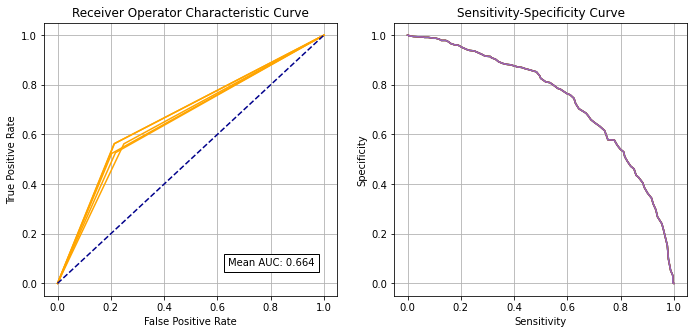

In [28]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
for k in range(5):
    ax1.plot(fpr_kfold[k], tpr_kfold[k], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'Mean AUC: {mean_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(sensitivity_kfold[k], specificity_kfold[k])
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
plt.savefig(
    f'./output/{notebook}_{model_text}_roc_sens_spec.jpg', 
    dpi=300)

plt.show()

#### Identify cross-over of sensitivity and specificity

In [29]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [30]:
intersections = []
for k in range(5):
    sens = np.array(sensitivity_kfold[k])
    spec = np.array(specificity_kfold[k])
    df = pd.DataFrame()
    df['sensitivity'] = sens
    df['specificity'] = spec
    df['spec greater sens'] = spec > sens

    # find last index for senitivity being greater than specificity 
    mask = df['spec greater sens'] == False
    last_id_sens_greater_spec = np.max(df[mask].index)
    locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
    points = df.iloc[locs][['sensitivity', 'specificity']]

    # Get intersetction with line of x=y
    a1 = list(points.iloc[0].values)
    a2 = list(points.iloc[1].values)
    b1 = [0, 0]
    b2 = [1, 1]

    intersections.append(get_intersect(a1, a2, b1, b2)[0])

mean_intersection = np.mean(intersections)
sd_intersection = np.std(intersections)
print (f'\nMean intersection: {mean_intersection:0.4f}')
print (f'SD intersection: {sd_intersection:0.4f}')


Mean intersection: 0.6764
SD intersection: 0.0063


## SHAP values

Get SHAP values for each of the 5 k-fold splits. Use the training set to setup the SHAP explainer, and use it to get the SHAP value for each patient in the test set. This will return a SHAP value for each patient for each feature.

Get a SHAP value per feature for each k-fold by taking the average.

Look at the range of SHAP values for each feature across the k-fold splits

### Get SHAP values
'Raw' SHAP values from XGBoost model are log odds ratios. 

In [31]:
# Set up lists to store shap values
shap_values_extended_kfold = []
shap_values_kfold = []

for k in range(5):
    
    # Set up explainer using typical feature values from training set
    explainer = shap.TreeExplainer(model_kfold[k], X_train_kfold[k])

    # Get Shapley values along with base and features
    shap_values_extended = explainer(X_test_kfold[k])
    shap_values_extended_kfold.append(shap_values_extended)
    # Shap values exist for each classification in a Tree; 1=give thrombolysis
    shap_values = shap_values_extended.values
    shap_values_kfold.append(shap_values)       

    print (f'Completed {k+1} of 5')

Completed 1 of 5
Completed 2 of 5
Completed 3 of 5
Completed 4 of 5
Completed 5 of 5


### Get average SHAP value for each k-fold
(one per feature, an average of the patients in the test set)

The list (shap_values_mean_kfold) stores a dataframe for each kfold split (shap_values_mean). The dataframe contains the calculated average Shap value for each feature for the test set. 

In [32]:
# Set up list to store results
shap_values_mean_kfold = []
features = list(X_train_kfold[0])

# For each k-fold calculate and store the mean Shap value per feature
for k in range(5):
    shap_values = shap_values_kfold[k]
    # Get mean Shap values for each feature
    shap_values_mean = pd.DataFrame(index=features)
    shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
    shap_values_mean['abs_mean_shap'] = np.abs(shap_values_mean)
    shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
    shap_values_mean['rank'] = shap_values_mean['mean_abs_shap'].rank(
        ascending=False).values
    shap_values_mean.sort_index()
    shap_values_mean_kfold.append(shap_values_mean)

Look at the average Shap values for the first k-fold split.

In [33]:
shap_values_mean_kfold[0]

,mean_shap,abs_mean_shap,mean_abs_shap,rank
Arrival-to-scan time,-0.062031,0.062031,0.294041,4.0
Infarction,0.000000,0.000000,0.000000,7.0
Stroke severity,-0.013196,0.013196,0.551622,1.0
Precise onset time,0.031189,0.031189,0.401897,3.0
Prior disability level,0.035761,0.035761,0.436681,2.0
Use of AF anticoagulants,0.000070,0.000070,0.103821,6.0
Onset-to-arrival time,-0.029039,0.029039,0.247956,5.0


### Examine consistency across top SHAP values (mean |Shap|)

Calculate the range of Shap values for each feature across the kfold splits. 'Raw' Shap values from XGBoost model are log odds ratios. 

In [34]:
# Build df for k fold values
df_mean_abs_shap = pd.DataFrame()
for k in range(5):
    df_mean_abs_shap[f'{k}'] = shap_values_mean_kfold[k]['mean_abs_shap']
    
# Build df to show min, median, and max
df_mean_abs_shap_summary = pd.DataFrame()
df_mean_abs_shap_summary['min'] = df_mean_abs_shap.min(axis=1)
df_mean_abs_shap_summary['median'] = df_mean_abs_shap.median(axis=1) 
df_mean_abs_shap_summary['max'] = df_mean_abs_shap.max(axis=1)
df_mean_abs_shap_summary.sort_values('median', inplace=True, ascending=False)

In [35]:
df_mean_abs_shap_summary

,min,median,max
Stroke severity,0.469272,0.515694,0.551622
Prior disability level,0.424441,0.436681,0.491343
Precise onset time,0.292516,0.401897,0.447253
Arrival-to-scan time,0.294041,0.304198,0.318648
Onset-to-arrival time,0.209314,0.230033,0.247956
Use of AF anticoagulants,0.055095,0.079052,0.103821
Infarction,0.000000,0.000000,0.000000


For models with lots of features, extract the top 10 to use here on.

In [36]:
top_10_shap = list(df_mean_abs_shap_summary.head(10).index)

Plot the range of SHAP values for each feature across the 5 k-fold splits

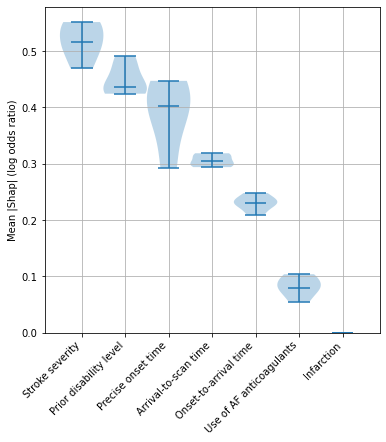

In [37]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(df_mean_abs_shap.loc[top_10_shap].T,
               showmedians=True,
               widths=1)
ax1.set_ylim(0)
labels = top_10_shap
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('Mean |Shap| (log odds ratio)')
plt.savefig(
    f'output/{notebook}_{model_text}_shap_kfold_violin.jpg', 
    dpi=300)
plt.show()

## Feature importances
### Examine consitency of feature importances

In [38]:
# Build df for k fold values
df_importances = pd.DataFrame()
for k in range(5):
    df_importances[f'{k}'] = feature_importance_kfold[k]

# Build df to show min, median, and max
df_importances_summary = pd.DataFrame()
df_importances_summary['min'] = df_importances.min(axis=1)
df_importances_summary['median'] = df_importances.median(axis=1) 
df_importances_summary['max'] = df_importances.max(axis=1)
df_importances_summary.sort_values('median', inplace=True, ascending=False)
importance_features_index = list(df_importances_summary.index)
# Add feature names back in
df_importances_summary['feature'] = \
    [list(X_train)[feat] for feat in importance_features_index]
df_importances_summary.set_index('feature', inplace=True)

In [39]:
df_importances_summary

,min,median,max
feature,,,
Precise onset time,0.392276,0.427986,0.441626
Use of AF anticoagulants,0.202440,0.215143,0.226029
Prior disability level,0.164072,0.171589,0.180174
Stroke severity,0.084191,0.096703,0.102428
Arrival-to-scan time,0.046916,0.051572,0.056909
Onset-to-arrival time,0.042045,0.045115,0.050731
Infarction,0.000000,0.000000,0.000000


For models with lots of features, extract the top 10 to use here on.

In [40]:
top_10_importances = list(df_importances_summary.head(10).index)

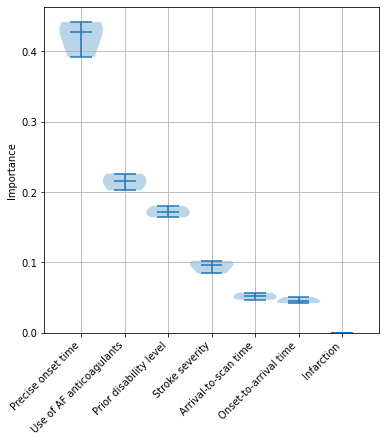

In [41]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(df_importances_summary.loc[top_10_importances].T,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = top_10_importances
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('Importance')
plt.savefig(f'output/{notebook}_{model_text}_importance_kfold_violin.jpg', 
            dpi=300)
plt.show()

### Compare SHAP and feature importances

Do they have the same rank of features?

In [42]:
df_compare_shap_importance = pd.DataFrame()
df_compare_shap_importance['Shap'] = df_mean_abs_shap_summary.head(10).index
df_compare_shap_importance['Importance'] = df_importances_summary.head(10).index
df_compare_shap_importance

,Shap,Importance
0,Stroke severity,Precise onset time
1,Prior disability level,Use of AF anticoagulants
2,Precise onset time,Prior disability level
3,Arrival-to-scan time,Stroke severity
4,Onset-to-arrival time,Arrival-to-scan time
5,Use of AF anticoagulants,Onset-to-arrival time
6,Infarction,Infarction


In [43]:
df_shap_importance = pd.DataFrame()
df_shap_importance['Shap'] = df_mean_abs_shap_summary['median']
df_shap_importance = df_shap_importance.merge(
    df_importances_summary['median'], left_index=True, right_index=True)
df_shap_importance.rename(columns={'median':'Importance'}, inplace=True)
df_shap_importance.sort_values('Shap', inplace=True, ascending=False)
df_shap_importance.head(10)

,Shap,Importance
Stroke severity,0.515694,0.096703
Prior disability level,0.436681,0.171589
Precise onset time,0.401897,0.427986
Arrival-to-scan time,0.304198,0.051572
Onset-to-arrival time,0.230033,0.045115
Use of AF anticoagulants,0.079052,0.215143
Infarction,0.000000,0.000000


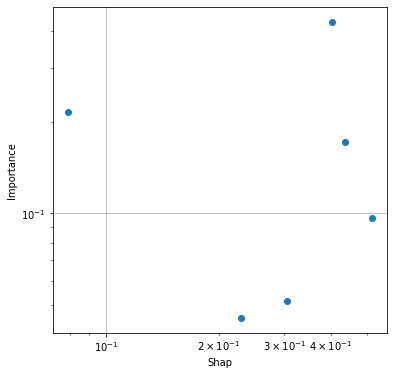

In [44]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(df_shap_importance['Shap'],
            df_shap_importance['Importance'])

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Shap')
ax1.set_ylabel('Importance')
ax1.grid()
plt.savefig(
    f'output/{notebook}_{model_text}_shap_importance_correlation.jpg',
    dpi=300)
plt.show()

## Further analysis of one k-fold

Having established that Shap values have good consistency across k-fold replictaes, here we show more detail on Shap using the first k_fold replicate.

We will look into detailed Shap values for the first train/test split.

In [45]:
# Get all key values from first k fold
model = model_kfold[0]
shap_values = shap_values_kfold[0]
shap_values_extended = shap_values_extended_kfold[0]
importances = feature_importance_kfold[0]
y_pred = y_pred_kfold[0]
y_prob = y_prob_kfold[0]
X_train = X_train_kfold[0]
X_test = X_test_kfold[0]
y_train = y_train_kfold[0]
y_test = y_test_kfold[0]

### Beeswarm plot

A Beeswarm plot shows all points. The feature value for each point is shown by the colour, and its position indicates the Shap value for that instance.

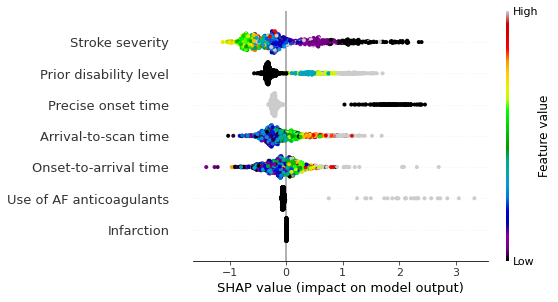

In [46]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features,
                  max_display=8,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)
plt.savefig(
        f'output/{notebook}_{model_text}_beeswarm_kfold0.jpg', 
        dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Plot Waterfall and decision plot plots for instances with high probability of making a different decision

Waterfall plot and decision plots are alternative ways of plotting the influence of features for individual cases.

In [47]:
# Get the location of an example of a high probablility instance
location_high_probability = np.where(y_prob == np.max(y_prob))[0][0]

An example with high probability of a low thrombolysing unit making deciding not to give thrombolysis to a patient when the benchmark hospitals would.

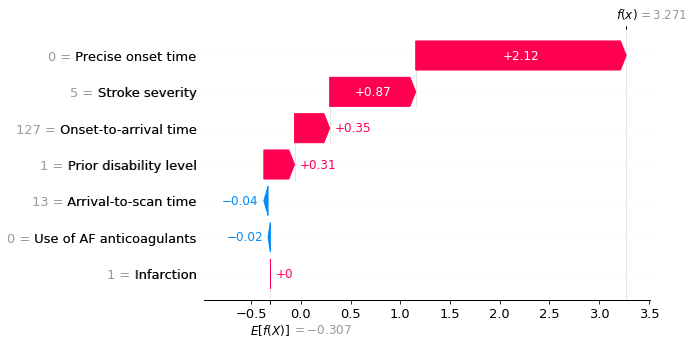

In [49]:
#fig = waterfall.waterfall(shap_values_extended[location_high_probability],
#                           show=False, max_display=8, y_reverse=True)
fig = shap.plots.waterfall(shap_values_extended[location_high_probability],
                           show=False, max_display=8)
plt.savefig(
    f'output/{notebook}_{model_text}_waterfall_high_kfold0.jpg', 
    dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Show the relationship between feature value and Shap value for influential features.

#### Show SHAP as a scatter plot

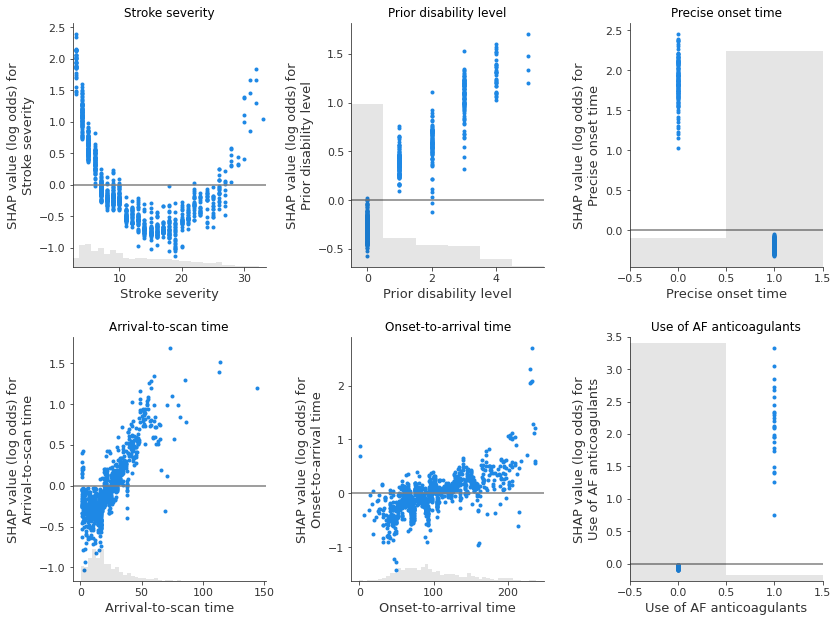

In [50]:
feat_to_show = top_10_shap[0:6]

fig = plt.figure(figsize=(12,9))
for n, feat in enumerate(feat_to_show):    
    ax = fig.add_subplot(2,3,n+1)
    shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0, ax=ax, 
                       show=False)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0,0], c='0.5')    
    
    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
    
fig.savefig(f'output/{notebook}_{model_text}_shap_scatter_kfold0.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)

#### Show Shap as a violin plot

In [51]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    rotation [integer] = xtick label rotation
    feat [string] = used in the axis label, the feature that is being plotted
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=10)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'Shap values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

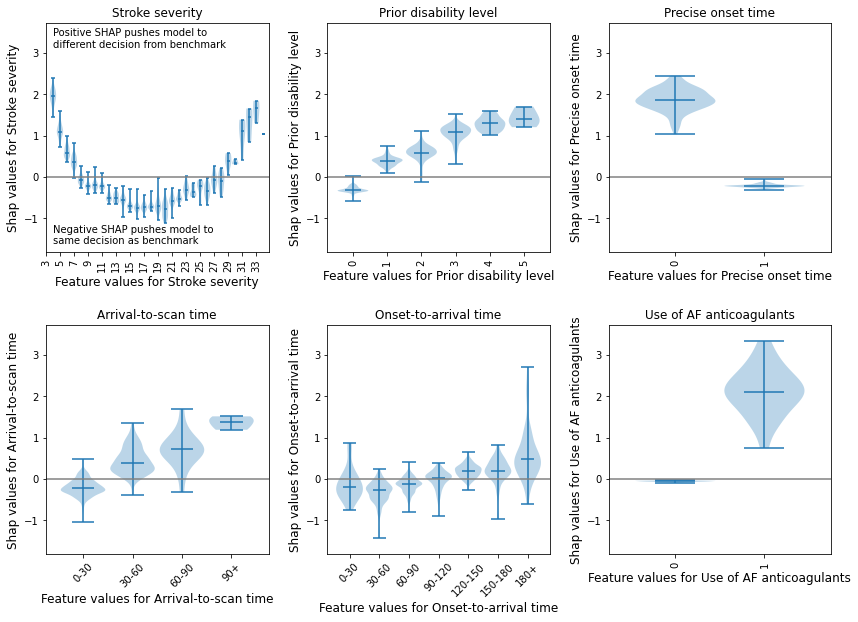

In [52]:
feat_to_show = top_10_shap[0:6]

# Get shap min and max (to put all charts on same scale)
shap_min = shap_values_extended.values.min()
shap_max = shap_values_extended.values.max()

fig = plt.figure(figsize=(12,9))
# for each feature, prepare the data for the violin plot.
# data either already in categories, or if there's more than 50 unique values
# for a feature then assume it needs to be binned, and a violin for each bin
for n, feat in enumerate(feat_to_show):    
    feature_data = shap_values_extended[:, feat].data
    feature_shap = shap_values_extended[:, feat].values

    # if feature has more that 50 unique values, then assume it needs to be 
    # binned (other assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data, create a violin per bin
        
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = min(16, np.int((feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list =  [f'{i*step}-{(i+1)*step}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 90
        
        # create list of unique categories in the feature data
        category_list = np.unique(feature_data)
        category_list = [int(i) for i in category_list]

    # create a list, each entry contains the corresponsing Shap value for that 
    # category (or bin). A violin will represent each list.    
    shap_per_category = []
    for category in category_list:
        mask = feature_data == category
        shap_per_category.append(feature_shap[mask])

    # create violin plot
    ax = fig.add_subplot(2, 3 ,n+1)
    ax.violinplot(shap_per_category, showmedians=True, widths=0.9)    
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([0, len(feature_values)], [0,0],c='0.5')   

    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    
    # Adjust stroke severity tickmarks
    if feat == 'Stroke severity':
        ax.set_xticks(np.arange(0, len(category_list), 2))
        ax.set_xticklabels(category_list[0::2])
            
    # Add title
    ax.set_title(feat) 
    
    # Set ylims
    ax.set_ylim(shap_min - 0.4, shap_max + 0.4)
    
    # Add direction of SHAP on first chart
    if n == 0:
        txt = "Negative SHAP pushes model to\nsame decision as benchmark"
        ax.text(1, shap_min - 0.2, txt)
        txt = "Positive SHAP pushes model to\ndifferent decision from benchmark"
        ax.text(1, shap_max - 0.2, txt)
            
plt.tight_layout(pad=2)
    
fig.savefig(
    f'output/{notebook}_{model_text}_shap_violin_kfold0.jpg', dpi=300,
     bbox_inches='tight', pad_inches=0.2)

## Showing waterfall plots using probability values

Though SHAP values for XGBoost most accurately describe the effect on log odds ratio of classification, it may be easier for people to understand influence of features using probabilities. Here we plot waterfall plots using probabilities.

A disadvantage of this method is that it distorts the influence of some features - those features pushing the probability down from a low level to an even lower level get 'squashed' in apparent importance. This distortion is avoided when plotting log odds ratio, but at the cost of using an output that is poorly understandable by many.

In [53]:
# Set up explainer using typical feature values from training set
explainer_prob = shap.TreeExplainer(model, X_train, model_output='probability')

# Get Shapley values along with base and features
shap_values_extended_prob = explainer(X_test)
shap_values = shap_values_extended_prob.values

In [54]:
# Get the location of an example each of low and high probablility

location_high_probability = np.where(y_prob==np.max(y_prob))[0][0]

An example with high probability of a low thrombolysing unit making deciding not to give thrombolysis to a patient when the benchmark hospitals would.

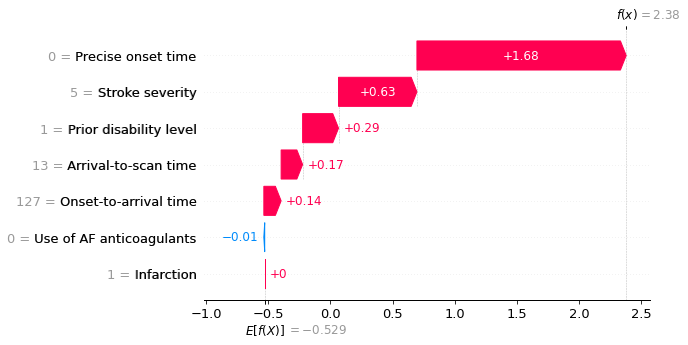

In [55]:
#fig = waterfall.waterfall(shap_values_extended_prob[location_high_probability],
#                           show=False, max_display=8, y_reverse=True)
fig = shap.plots.waterfall(shap_values_extended_prob[location_high_probability],
                           show=False, max_display=8)

plt.savefig(
    f'output/{notebook}_{model_text}_waterfall_high_probability_kfold0.jpg', 
    dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Observations

* We can predict those that will *not* receive thrombolysis at a local unit, out of those who will be thrombolysed by the majority of the benchmark hospitals, with 67% accuracy (AUC 0.733).

* The five most important distinguishing features are:
    * Stroke severity
    * Prior disability level
    * Precise onset time
    * Arrival-to-scan time
    * Onset-to-arrival time